#### VAR

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [12]:
plt.rcParams['figure.figsize'] = (10, 7.5)

#### US Macroeconomic Dataset

In [3]:
macro_data = sm.datasets.macrodata.load_pandas().data
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


We will predict the realgdp and realcons

In [9]:
# fig = px.line(macro_data, x='year', y=macro_data.columns[2:4], width=800, height=400,
#                  title='US Macro Economy Data', labels= {'year': 'Year'})

# fig.show()

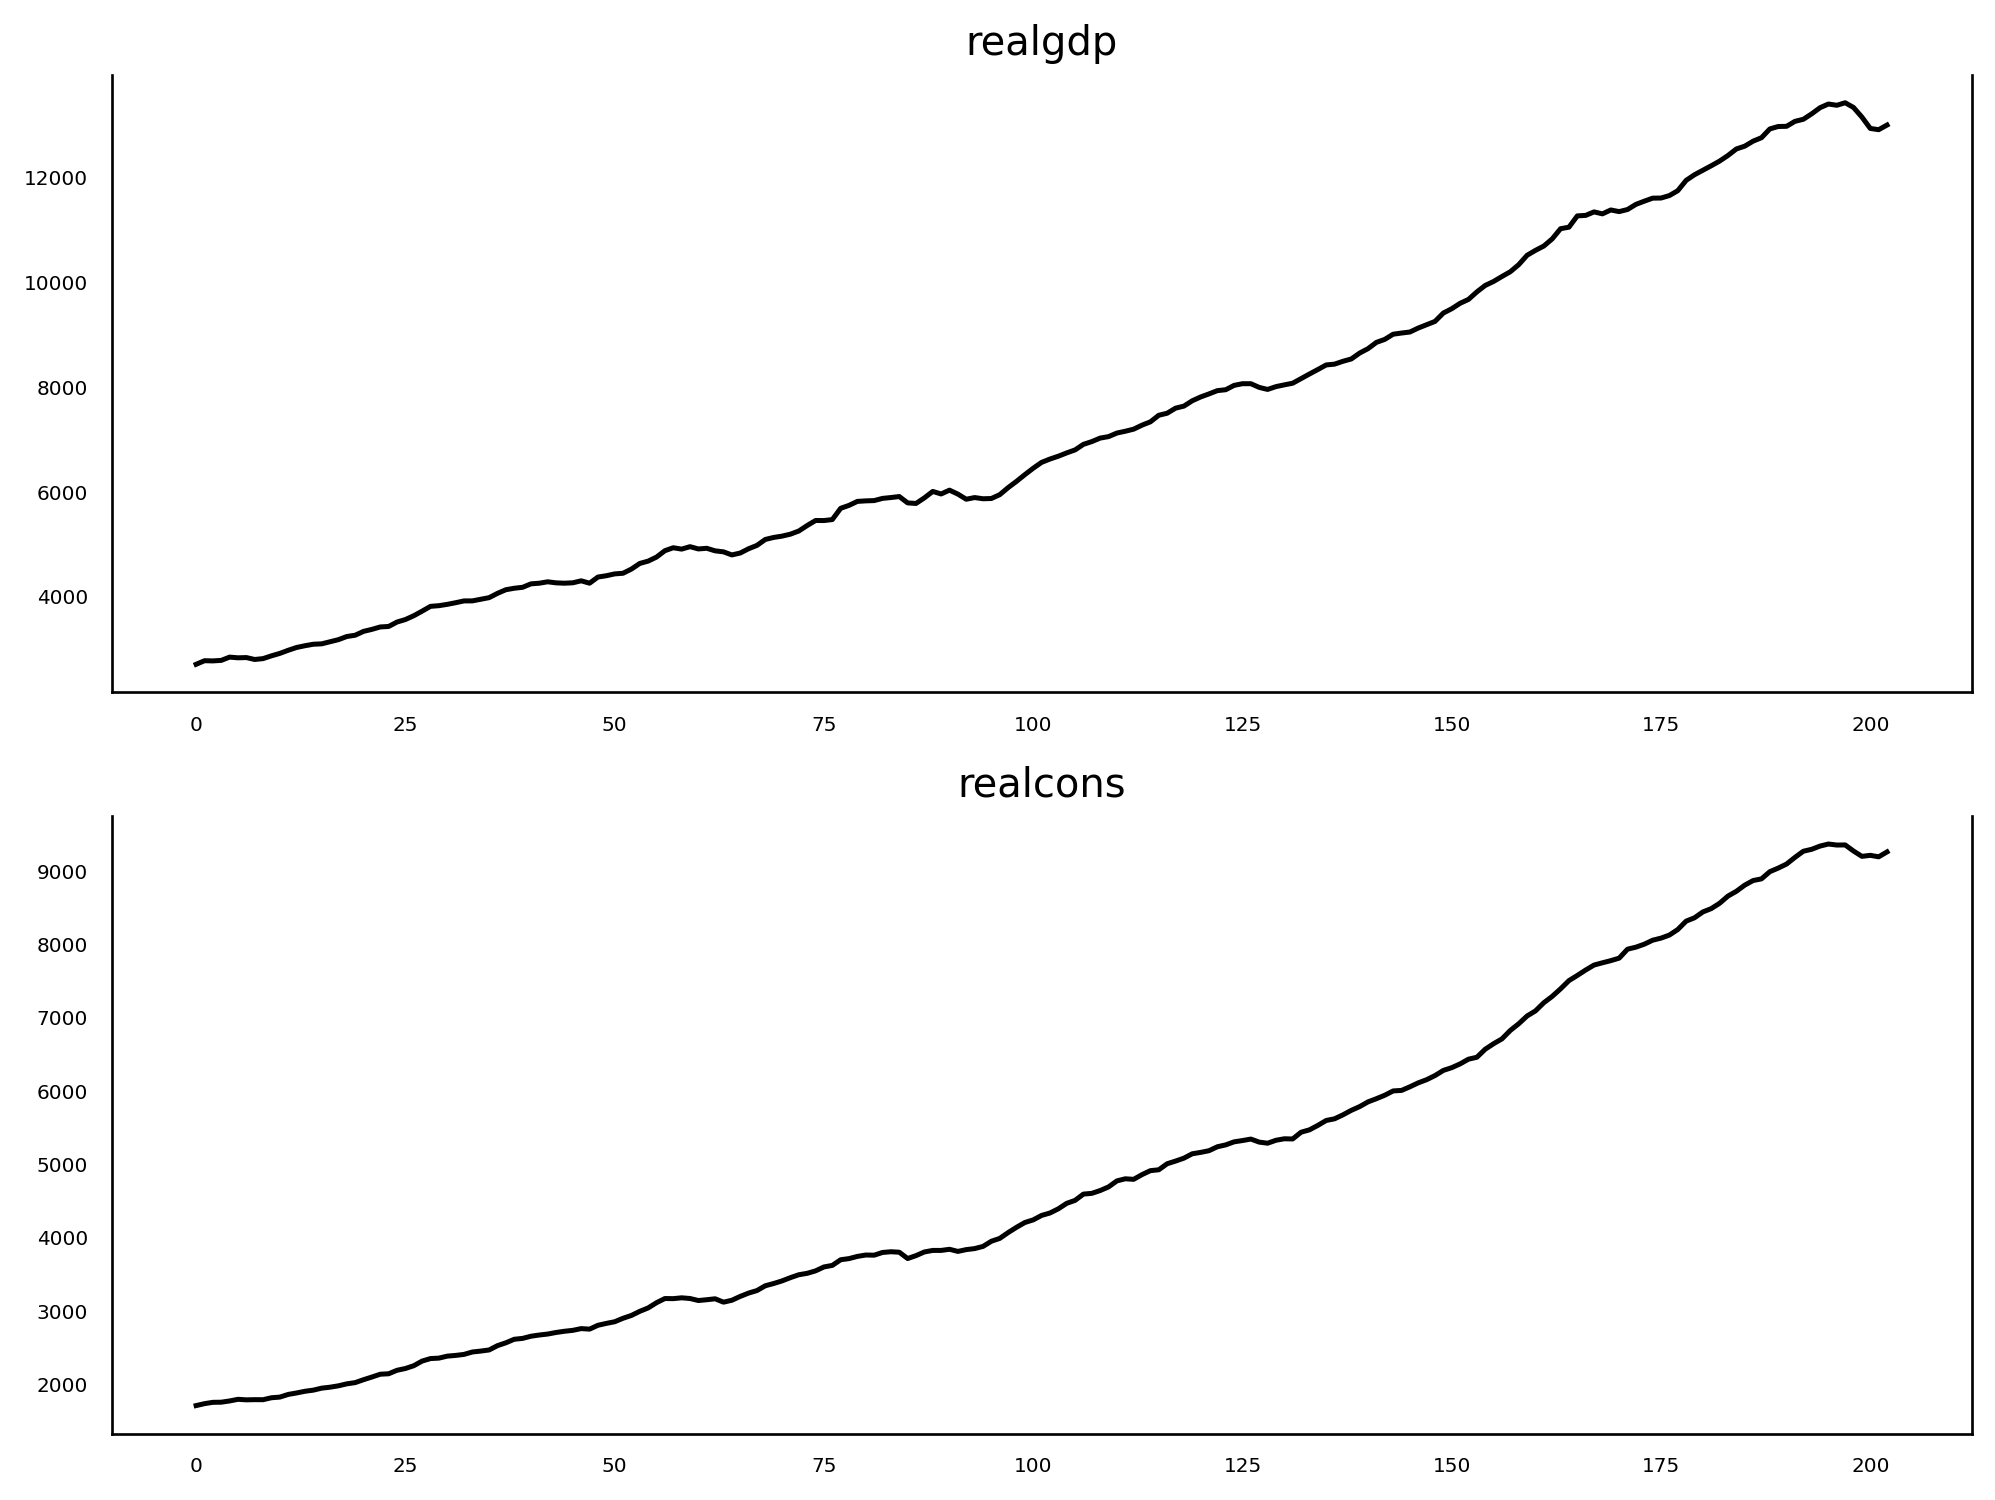

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'],color='k')
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'],color='k')
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

Since both of them have a trend it is non stationarity

In [28]:
# Adfuller Test is to test whether it is stationary or not, hypothesis is that it is stationary
ad_fuller_result_1 = adfuller(macro_data['realgdp'].diff()[1:])

print(f"realgdp")
print(f"ADF Statistic: {ad_fuller_result_1[0]}")
print(f"p-value: {ad_fuller_result_1[1]}")

print("------------------------")

ad_fuller_result_2 = adfuller(macro_data['realcons'].diff()[1:])

print(f"realcons")
print(f"ADF Statistic: {ad_fuller_result_2[0]}")
print(f"p-value: {ad_fuller_result_2[1]}")

realgdp
ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08
------------------------
realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


We are using VAR model with no intgration so we will not use the differencing, we are working with AR so will consider only AR portion of the model, q will be 0.

In [19]:
def optimize_VAR(endog):
    """
        Return a df with parameters and corresponding MSE

        endog: observed time series
    """

    results = []

    for i in tqdm_notebook(range(15)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(disp=False)
        except:
            continue

        mse = model.mse
        results.append([i, mse])

    result_df = pd.DataFrame(results, columns=['p', 'mse'])
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)

    return result_df

In [20]:
endog = macro_data[['realgdp', 'realcons']]
result_df = optimize_VAR(endog)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,mse
0,12,1.447305e+05
1,11,1.465396e+05
2,10,1.542755e+05
3,9,1.577328e+05
4,8,1.587703e+05
5,13,1.603303e+05
6,6,1.722453e+05
7,5,1.774247e+05
8,4,1.921087e+05
9,3,2.653719e+05


In [21]:
best_model = VARMAX(endog, order=(12, 0))
res = best_model.fit(disp=False)
print(res.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                             VAR(12)   Log Likelihood               -1983.751
                               + intercept   AIC                           4073.502
Date:                     Sun, 19 Jun 2022   BIC                           4249.102
Time:                             14:43:23   HQIC                          4144.543
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.17, 0.12   Jarque-Bera (JB):           4.73, 9.29
Prob(Q):                        0.68, 0.73   Prob(JB):                   0.09, 0.01
Heteroskedasticity (H):         1.74, 2.56   Skew:                       0.3

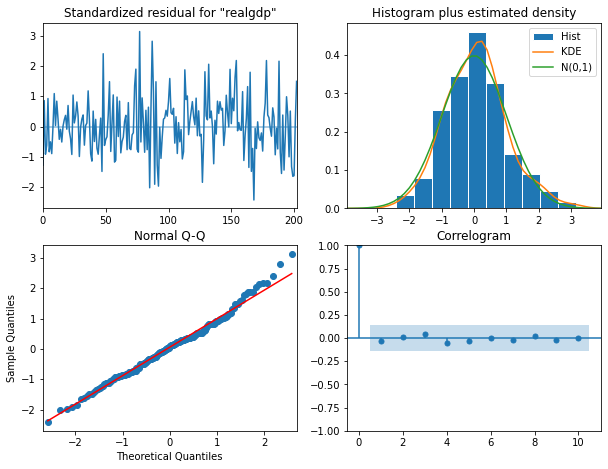

In [23]:
res.plot_diagnostics()
plt.show()

In [24]:
n_forecast = 3

predict = res.get_prediction(end= best_model.nobs+n_forecast)
idx = np.arange(len(predict.predicted_mean))

predict.predicted_mean.tail(3)

,realgdp,realcons
204,13169.755820,9296.761516
205,13196.641221,9295.401446
206,13233.295092,9296.085841


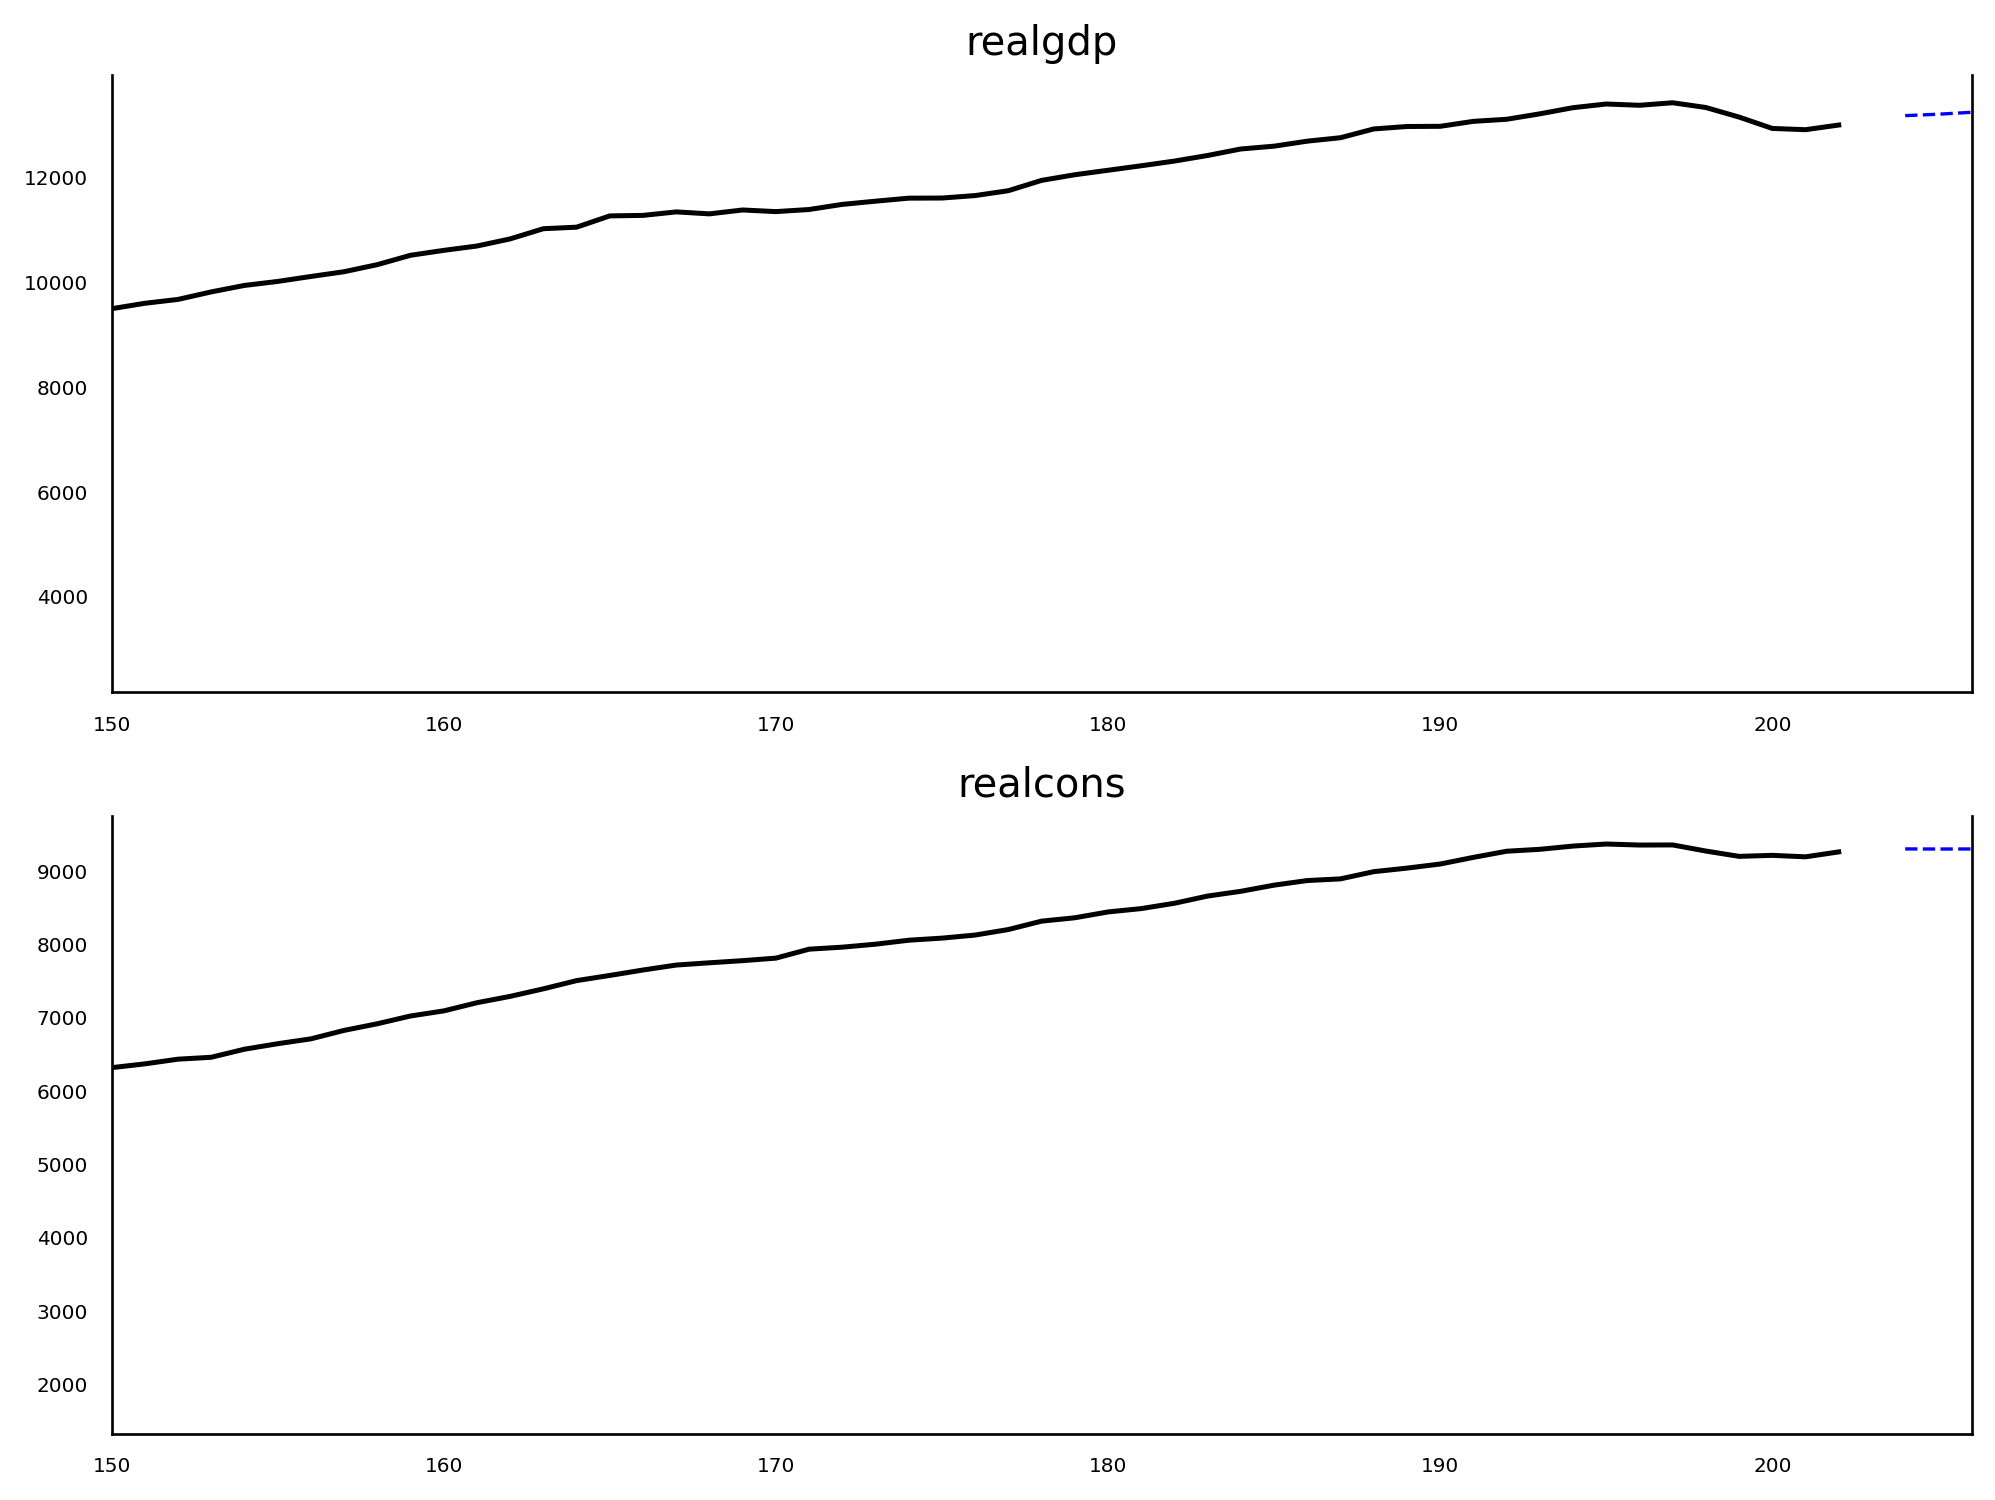

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)

ax1.plot(macro_data['realgdp'],color='k')
ax1.plot(idx[-n_forecast :], predict.predicted_mean.realgdp[-n_forecast :], 
        color='b',ls='--', linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)

ax2.plot(macro_data['realcons'],color='k')
ax2.plot(idx[-n_forecast :], predict.predicted_mean['realcons'][-n_forecast :], 
        color='b',ls='--', linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

VAR assumes both the variables are causing each other realcons cld be used to predict realgdp and vice versa<br>
So we will run the statistical test to understand this further. Which creates hypothesis that the realcons doesnot cause realgdp.<br> We will run the test and if p-value is less than 0.05. We will reject the null hypothesis

In [30]:
print("Realcons causes realgdp")
print("-------------------------")

# We are taking the difference bcz grangercausalitytests is valid when the time series are stationary, optimal lag is for order 12
granger_1 = grangercausalitytests(macro_data[['realgdp', 'realcons']].diff()[1:], [12])

print("\nRealgdp causes realcons")
print("-------------------------")
granger_2 = grangercausalitytests(macro_data[['realcons', 'realgdp']].diff()[1:], [12])


Realcons causes realgdp
-------------------------

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=6.1144  , p=0.0000  , df_denom=165, df_num=12
ssr based chi2 test:   chi2=84.4900 , p=0.0000  , df=12
likelihood ratio test: chi2=69.8992 , p=0.0000  , df=12
parameter F test:         F=6.1144  , p=0.0000  , df_denom=165, df_num=12

Realgdp causes realcons
-------------------------

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=2.1147  , p=0.0185  , df_denom=165, df_num=12
ssr based chi2 test:   chi2=29.2218 , p=0.0037  , df=12
likelihood ratio test: chi2=27.1813 , p=0.0073  , df=12
parameter F test:         F=2.1147  , p=0.0185  , df_denom=165, df_num=12


#### VARMA

We saw VAR model, to accomodate the MA process we will use varma

In [35]:
def optimize_varma(endog, parameters_list):
    """
        Return a df with parameters and corresponding MSE

        endog: observed time series
        parameters_list: list of (p,q) to be tested
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, order=param).fit(disp=False)
        except:
            continue

        mse = model.mse
        results.append([param, mse])

    result_df = pd.DataFrame(results, columns=['(p,q)', 'mse'])
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)

    return result_df

In [36]:
endog = macro_data[['realgdp', 'realcons']]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p,q)
parameters_list = list(parameters)

result_df_VARMA = optimize_varma(endog, parameters_list)
result_df_VARMA

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",mse
0,"(1, 1)",1.518944e+05
1,"(3, 1)",1.774342e+05
2,"(3, 2)",1.845376e+05
3,"(3, 3)",1.981885e+05
4,"(3, 0)",2.653719e+05
5,"(0, 1)",5.722233e+05
6,"(2, 1)",6.647161e+05
7,"(1, 2)",7.167024e+05
8,"(0, 3)",9.394727e+05
9,"(1, 3)",1.259426e+06


In [37]:
best_model_VARMA = VARMAX(endog, order=(1, 1))
res_VARMA = best_model_VARMA.fit(disp=False)

print(res_VARMA.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  203
Model:                             VAR(12)   Log Likelihood               -1983.751
                               + intercept   AIC                           4073.502
Date:                     Sun, 19 Jun 2022   BIC                           4249.102
Time:                             15:14:50   HQIC                          4144.543
Sample:                                  0                                         
                                     - 203                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.17, 0.12   Jarque-Bera (JB):           4.73, 9.29
Prob(Q):                        0.68, 0.73   Prob(JB):                   0.09, 0.01
Heteroskedasticity (H):         1.74, 2.56   Skew:                       0.3

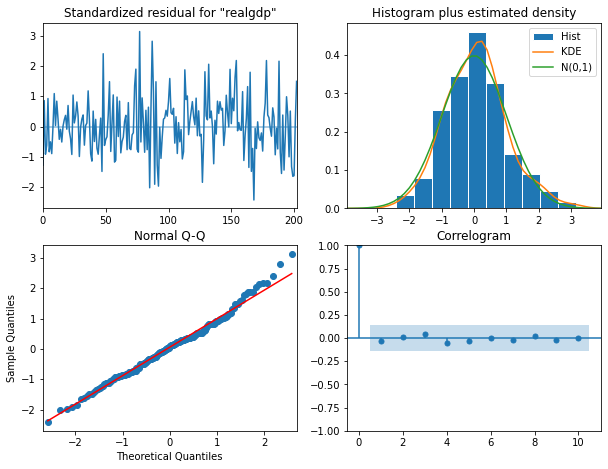

In [39]:
res_VARMA.plot_diagnostics()
plt.show()

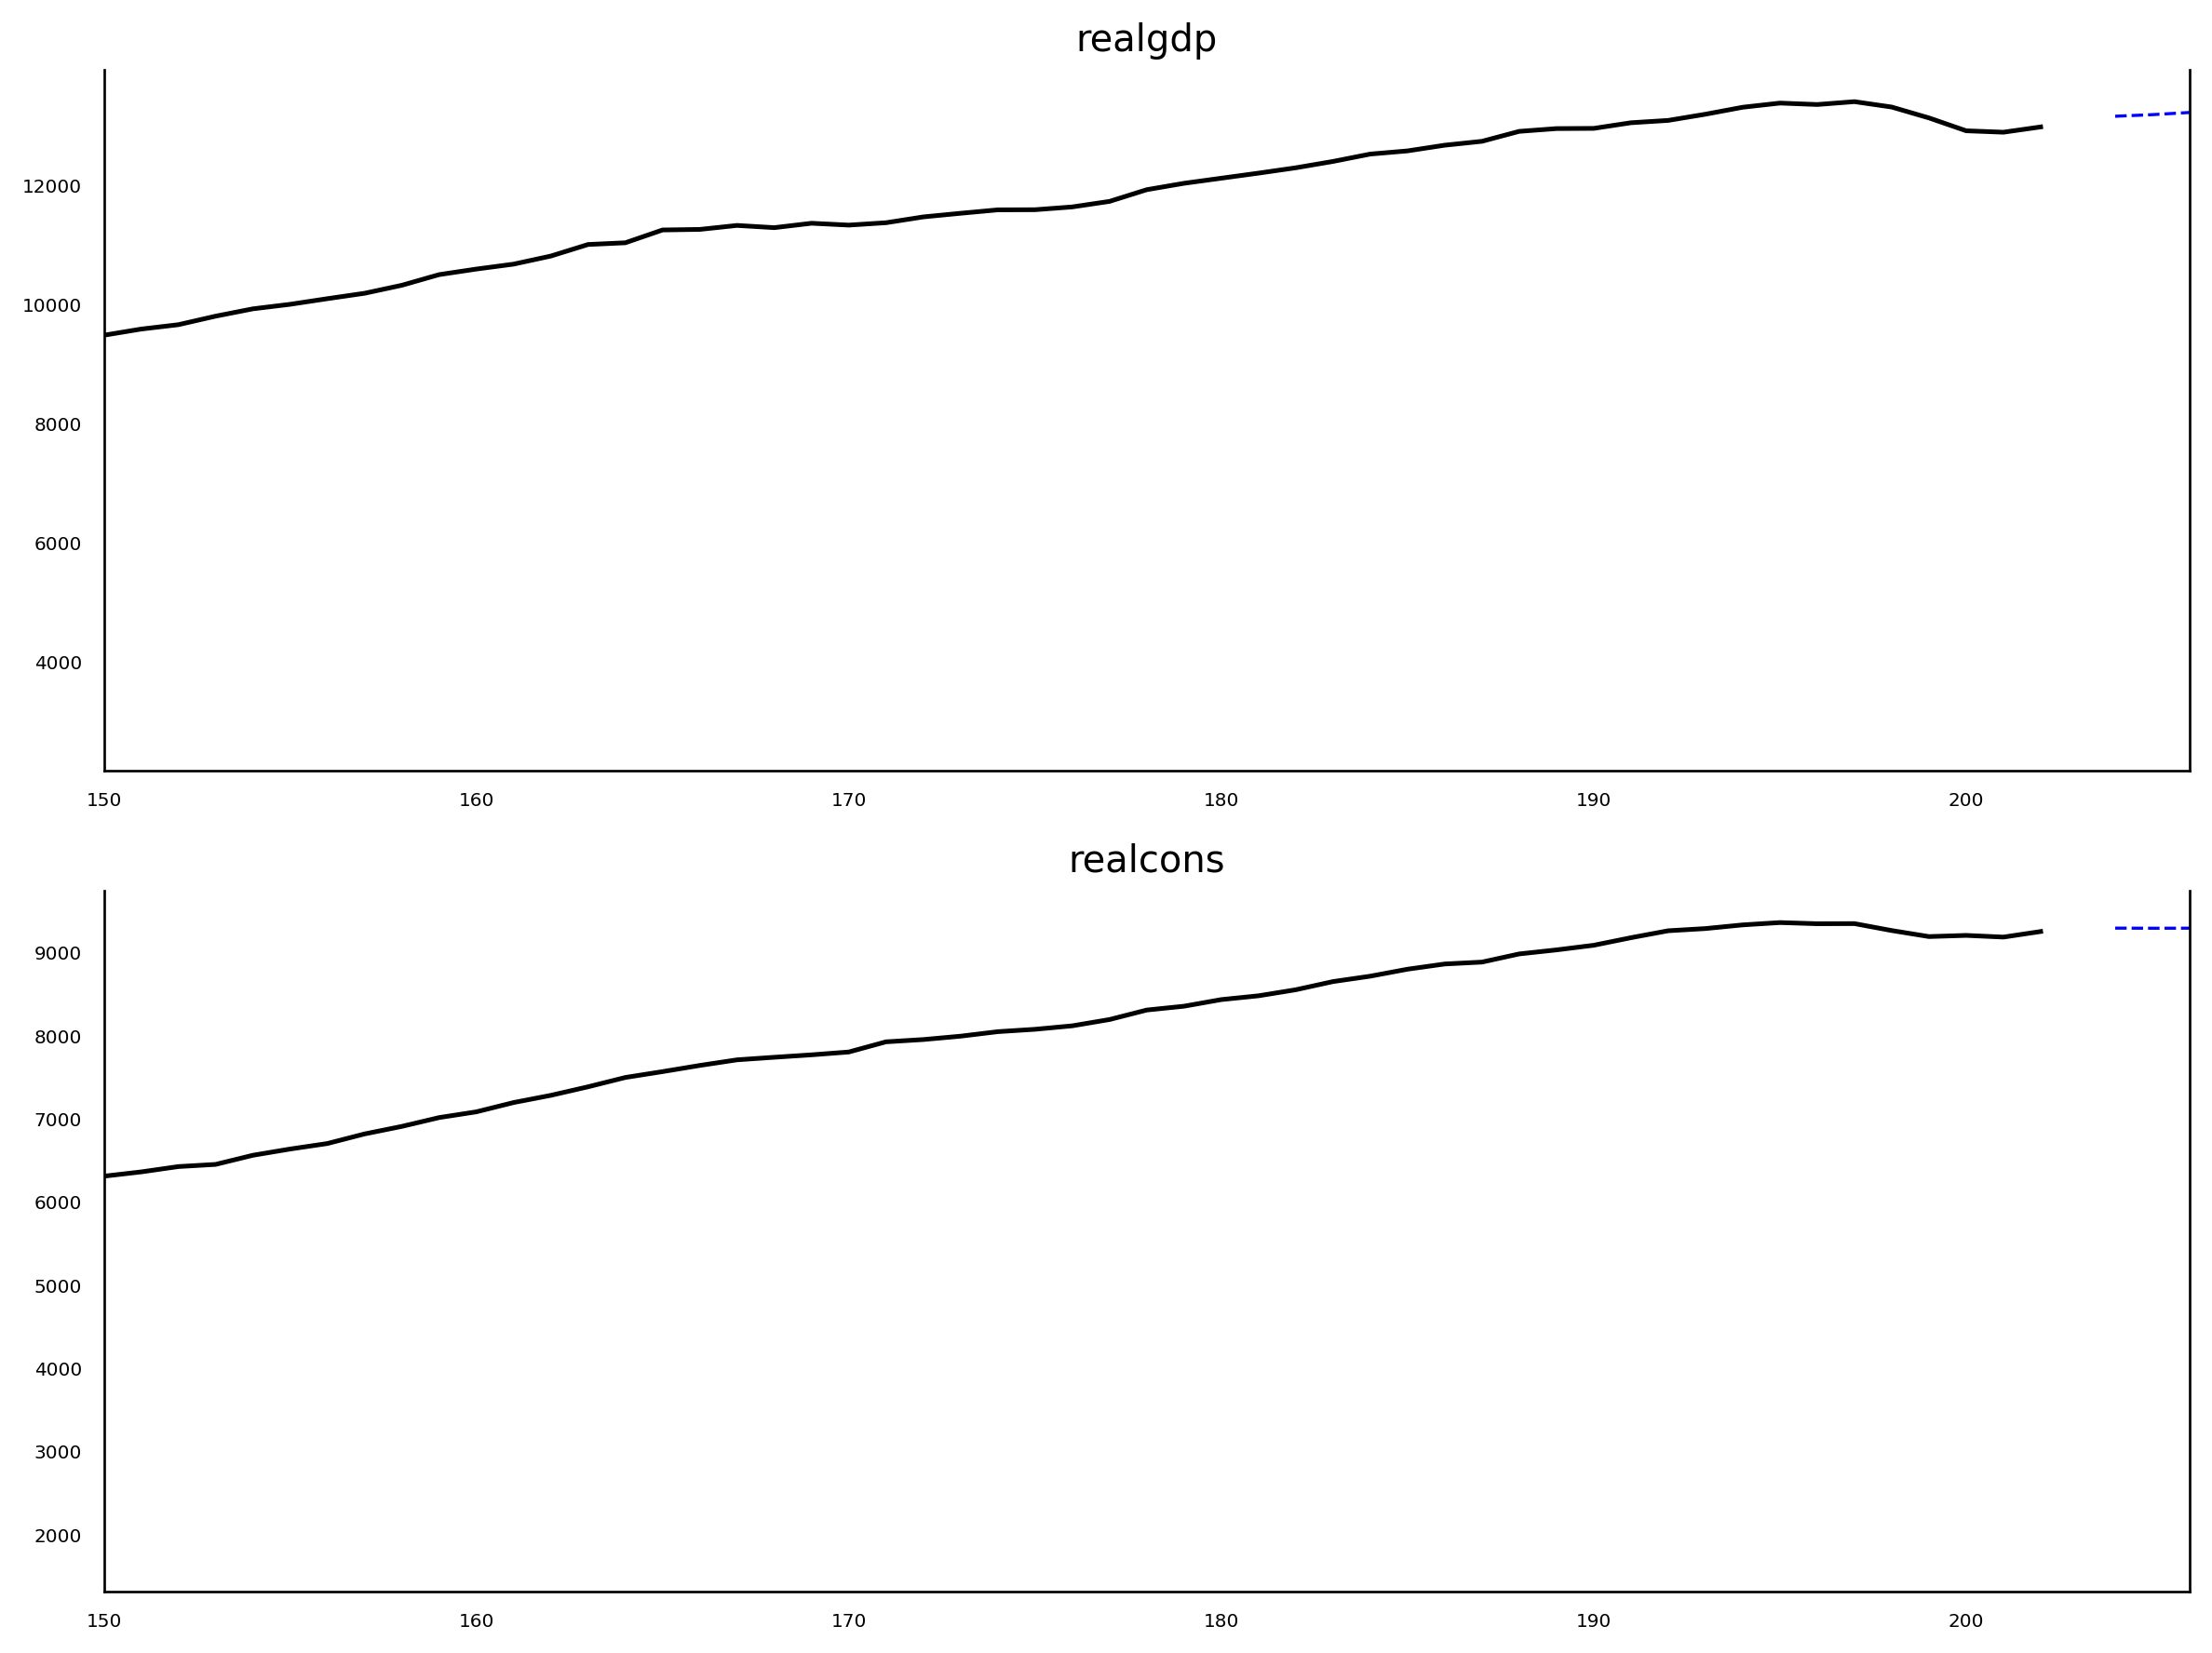

In [41]:
n_forecast = 3

predict = res_VARMA.get_prediction(end= best_model_VARMA.nobs+n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)
ax1.plot(macro_data['realgdp'],color='k')
ax1.plot(idx[-n_forecast :], predict.predicted_mean.realgdp[-n_forecast :],
        color='b',ls='--', linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)


ax2.plot(macro_data['realcons'],color='k')
ax2.plot(idx[-n_forecast :], predict.predicted_mean['realcons'][-n_forecast :],
        color='b',ls='--', linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()

#### VARMAX 
Allows to consider additional features(exog) to predict the target


In [42]:
def optimize_VARMAX(endog, exog, parameters_list):
    """
        Return a df with parameters and corresponding MSE

        endog: observed variables
        exog:  exogenous time series variables
        parameters_list: list of (p,q) tuples
    """

    results = []

    for param in tqdm_notebook(parameters_list):
        try:
            model = VARMAX(endog, exog, order=param).fit(disp=False)
        except:
            continue

        mse = model.mse
        results.append([param, mse])

    result_df = pd.DataFrame(results, columns=['(p,q)', 'mse'])
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)

    return result_df

In [43]:
endog = macro_data[['realgdp', 'realcons']][:200]

exog_cols = macro_data.columns.drop(["year",'quarter','realgdp','realcons'])
exog = macro_data[exog_cols][:200]

p = range(0, 4, 1)
q = range(0, 4, 1)

parameters = product(p, q)
parameters_list = list(parameters)

result_df_VARMAX = optimize_VARMAX(endog, exog, parameters_list)
result_df_VARMAX

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",mse
0,"(3, 3)",2327.110613
1,"(1, 3)",2337.712979
2,"(2, 3)",2342.579143
3,"(3, 2)",2364.168875
4,"(2, 2)",2397.198356
5,"(1, 2)",2431.297045
6,"(3, 1)",2465.106978
7,"(3, 0)",2519.682611
8,"(2, 1)",2541.775844
9,"(1, 1)",2575.697232


In [46]:
best_model_VARMAX = VARMAX(endog, exog, order=(3, 3))
res_VARMAX = best_model_VARMAX.fit(disp=False)

print(res_VARMAX.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realcons']   No. Observations:                  200
Model:                         VARMAX(3,3)   Log Likelihood               -1952.047
                               + intercept   AIC                           4002.094
Date:                     Sun, 19 Jun 2022   BIC                           4163.712
Time:                             17:12:03   HQIC                          4067.499
Sample:                                  0                                         
                                     - 200                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             1.25, 0.07   Jarque-Bera (JB):           4.89, 3.40
Prob(Q):                        0.26, 0.79   Prob(JB):                   0.09, 0.18
Heteroskedasticity (H):         1.83, 2.26   Skew:                      0.05

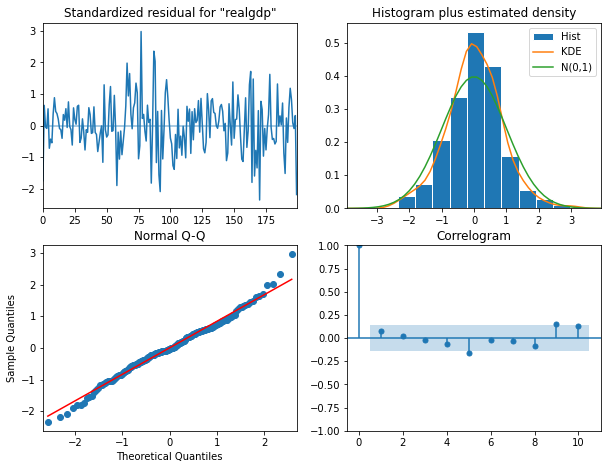

In [47]:
res_VARMAX.plot_diagnostics()
plt.show()

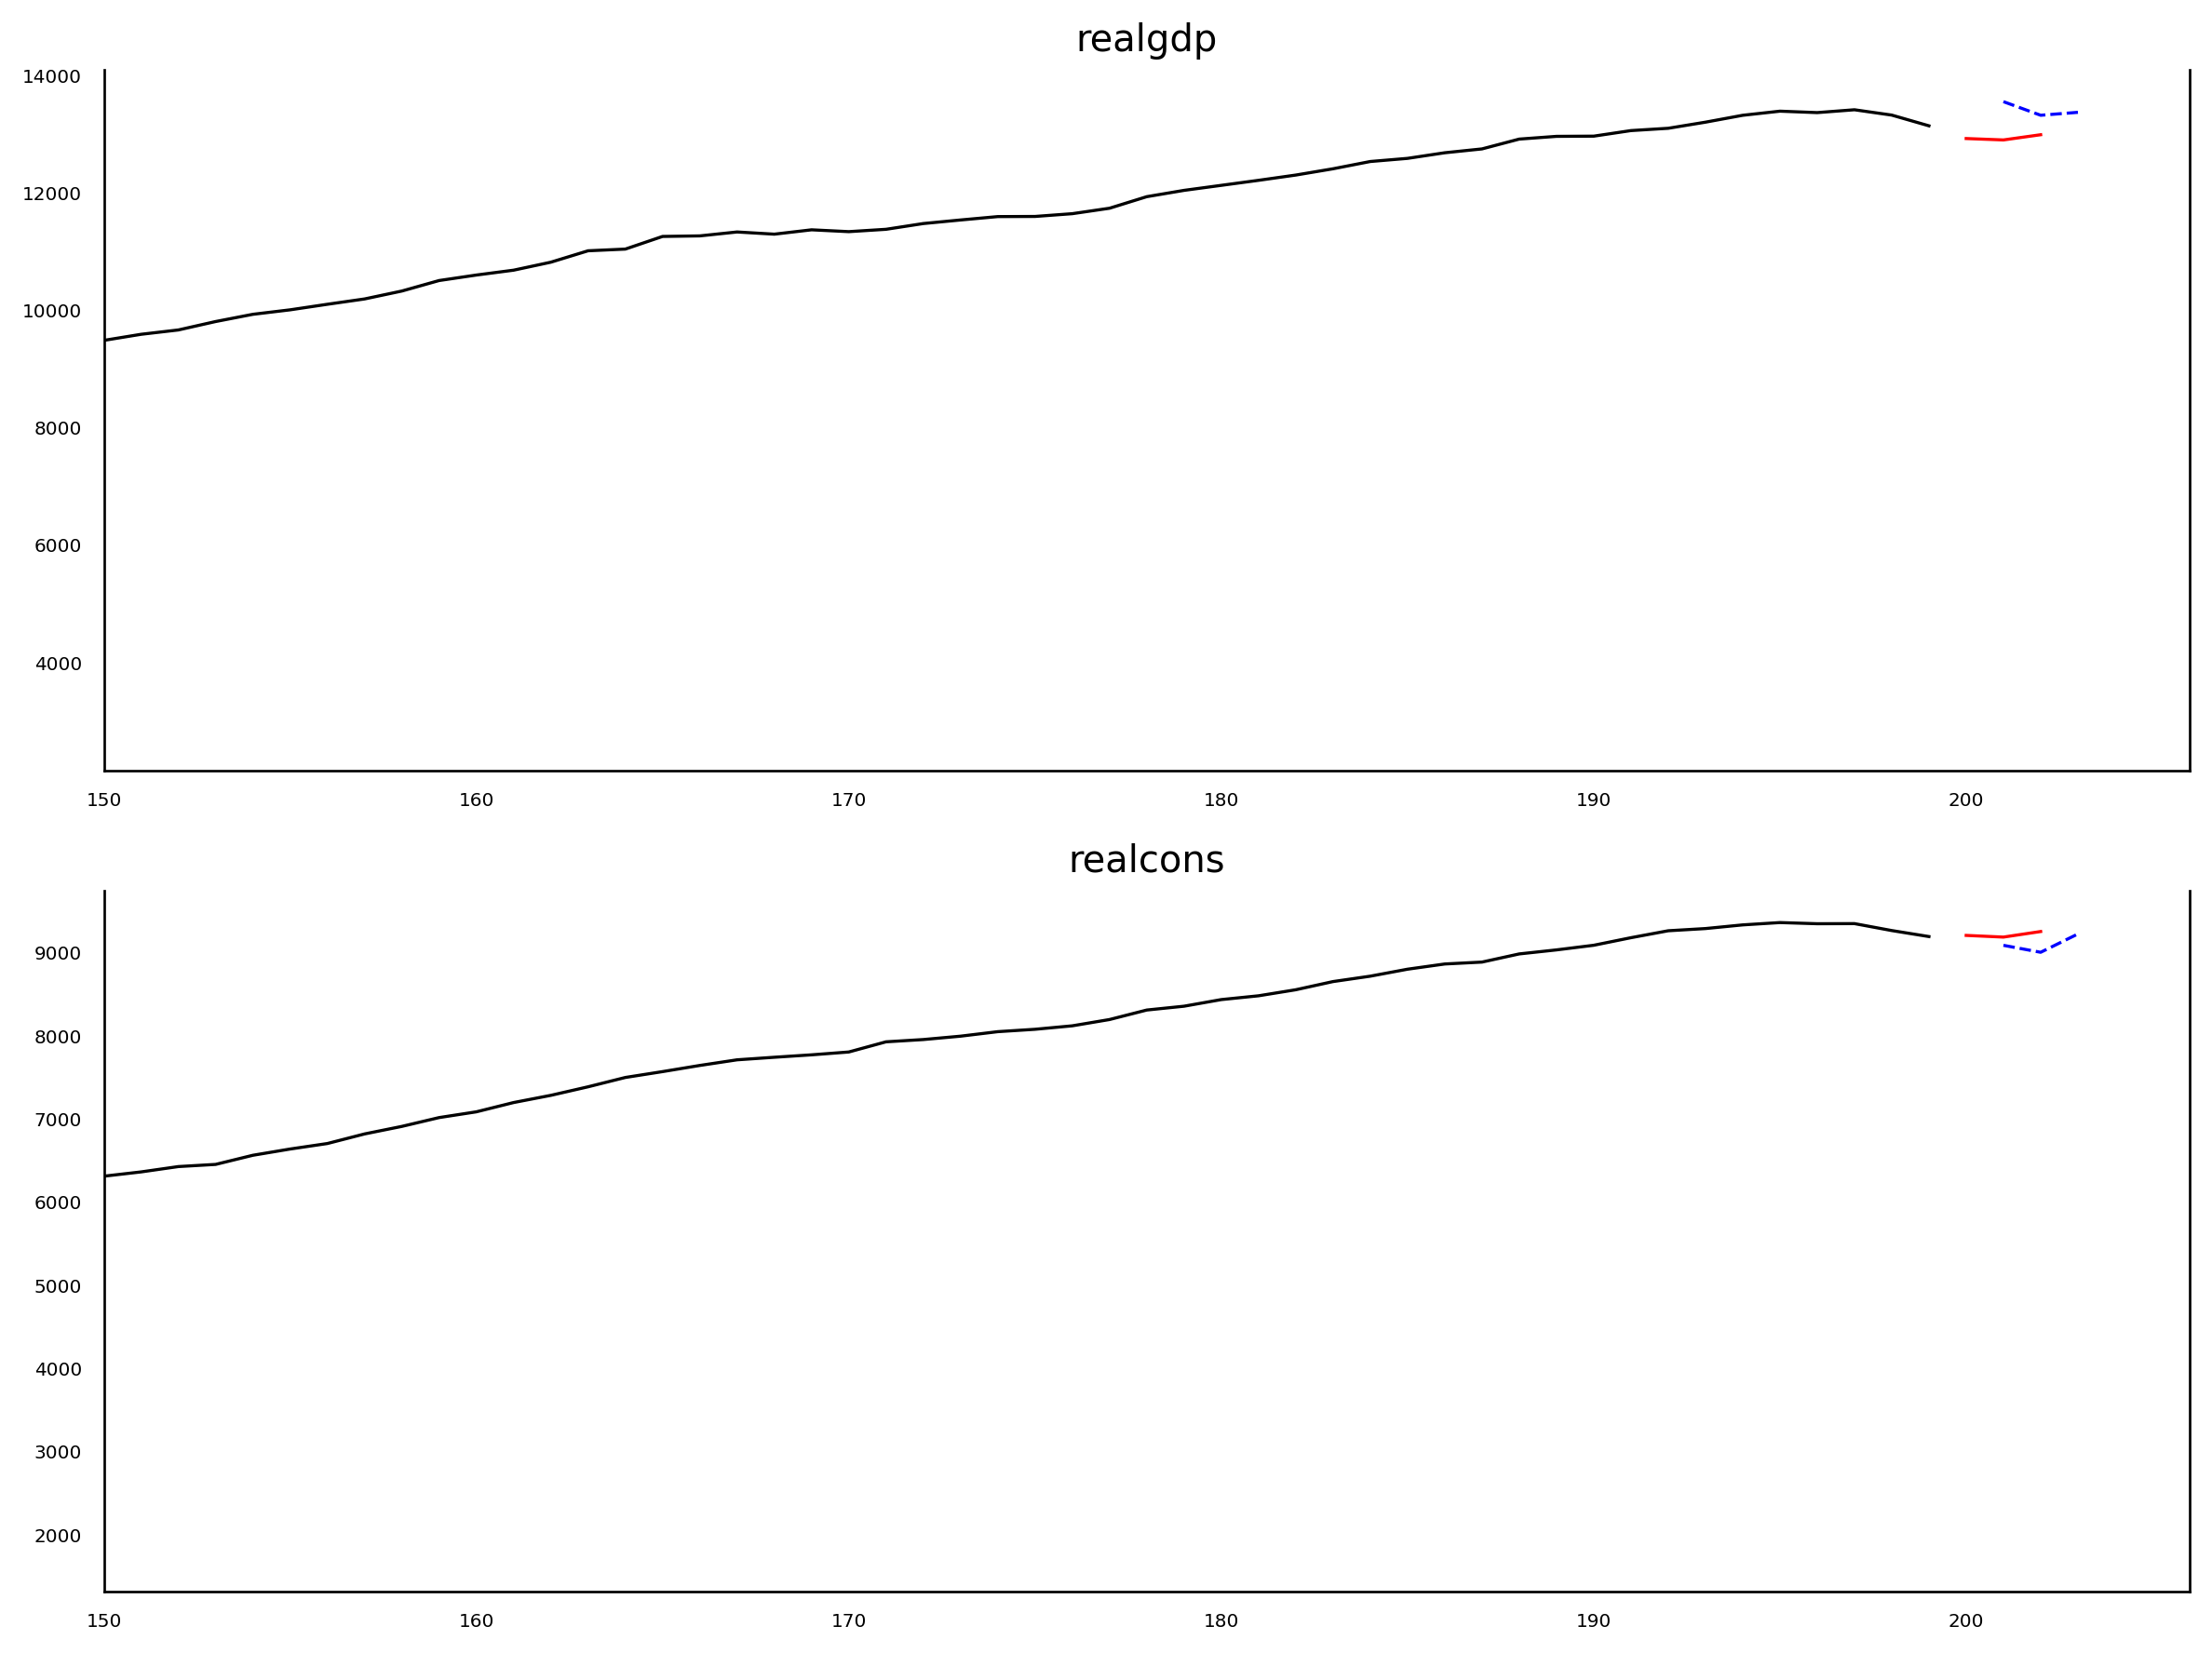

In [52]:
n_forecast = 3
predict = res_VARMAX.get_prediction(end= best_model_VARMAX.nobs+n_forecast,
                                    exog= exog.iloc[-4:])    
idx = np.arange(len(predict.predicted_mean))


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, dpi=240)
ax1.plot(macro_data['realgdp'][:200],color='k', linewidth=1)
ax1.plot(macro_data['realgdp'][200:], color='r', linewidth=1)
ax1.plot(idx[-n_forecast :], predict.predicted_mean.realgdp[-n_forecast :],
        color='b',ls='--', linewidth=1)
ax1.set_title('realgdp')
ax1.xaxis.set_ticks_position('none')
ax1.yaxis.set_ticks_position('none')
ax1.set_xlim(150, 206)
ax1.spines['top'].set_alpha(0)
ax1.tick_params(labelsize=6)


ax2.plot(macro_data['realcons'][:200],color='k', linewidth=1)
ax2.plot(macro_data['realcons'][200:], color='r', linewidth=1)
ax2.plot(idx[-n_forecast :], predict.predicted_mean['realcons'][-n_forecast :],
        color='b',ls='--', linewidth=1)
ax2.set_title('realcons')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.set_xlim(150, 206)
ax2.spines['top'].set_alpha(0)
ax2.tick_params(labelsize=6)

plt.tight_layout()
